In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.hamiltonian import Hamiltonian,PhaseSpaceState
import sympy 
from sympy import symbols, init_printing
init_printing()
from sympy import atan2,cos
from sympy.simplify.fu import TR11
from scipy.integrate import solve_ivp, odeint

from scipy.optimize import root_scalar

In [13]:
x,y,delta,J = sympy.symbols("x,y,delta,J")
state = PhaseSpaceState(qpvars=[y,x],values=[0,0])
Phi = (x*x + y*y) / 2
H = 4 * Phi * Phi - 3 * delta * Phi + sympy.simplify(Phi * TR11(cos(2 * atan2(y,x))))

ham = Hamiltonian(H,{delta:0},state)

Jdot = (x * ham.Lie_deriv(y) - y * ham.Lie_deriv(x)) / sympy.S(2)

flow_cons = sympy.Matrix([ham.flow[0],ham.flow[1],Jdot])

dyvars_cons=[y,x,J]
jac_cons = sympy.Matrix(3,3,lambda i,j: sympy.diff(flow_cons[i],dyvars_cons[j]))

Nflow_cons = sympy.lambdify(dyvars_cons + [delta],flow_cons)
Njac_cons = sympy.lambdify(dyvars_cons + [delta],jac_cons)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/sympy/matrices/matrices.py:3078: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()


In [14]:
# X coordinate of unstable equilibrium
def xunst(delta):
    return 0.5 * np.sqrt(3*delta - 1)

# Y coordinate of separatrix upper branch @ X=0
def ysx_max(delta):
    return 0.5 * (1 + np.sqrt(3*delta))

# Y coordinate of separatrix lower branch @ X=0
def ysx_min(delta):
    return 0.5 * (1 - np.sqrt(3*delta))

# Y coordinate of elliptic eq
def yell(delta):
    return 0.5 * np.sqrt(3*delta + 1)

# return the action and frequency of trajectory with 
# user-specified initial conditions
def get_action_and_frequency(delta,ic,solution=False):
    fun = lambda t,y: Nflow_cons(*y,delta).reshape(-1)
    xdot0 = fun(0,ic)[1]
    event = lambda t,y: y[1] if t>0 else xdot0
    event.terminal = True
    event.direction = xdot0
    soln=solve_ivp(
        fun,
        (0,np.infty),
        ic,
        method="Radau",
        jac = lambda t,y: Njac_cons(*y,delta),
        events = event,
        dense_output=solution,
        vectorized=True
    )
    T = soln.t_events[0][0]
    J = soln.y_events[0][0,-1]
    if solution:
        return J, 2*np.pi / T, soln
    return J, 2*np.pi / T

from scipy.integrate import quad

def Phi_unst(delta):
    x = xunst(delta)
    return 0.5 * x * x
def Phi_max(delta):
    y = ysx_max(delta)
    return 0.5 * y * y
def Phi_min(delta):
    y = ysx_min(delta)
    return 0.5 * y * y

# Action of complete sepatatrix trajectory
# is given by:
#    sx_upper_action(delta) + sx_lower_action(delta)
def sx_upper_action(delta):
    PhiU = Phi_unst(delta)
    PhiM = Phi_max(delta)
    Phim = Phi_min(delta)
    xM = PhiU+PhiM
    xm = PhiU+Phim
    
    res = np.sqrt((2*PhiU - xm) * (xM-2*PhiU ))
    res+= (xm+xM) * (0.5 * np.pi)
    arg = np.sqrt(2*PhiU - xm)/np.sqrt(xM-xm)
    res-=(xm+xM)*np.arcsin(arg)
    return res
def sx_lower_action(delta):
    PhiU = Phi_unst(delta)
    PhiM = Phi_max(delta)
    Phim = Phi_min(delta)
    xM = PhiU+PhiM
    xm = PhiU+Phim    
    res = np.sqrt((2*PhiU - xm) * (xM-2*PhiU ))
    arg = np.sqrt(2*PhiU - xm)/np.sqrt(xM-xm)
    res-=(xm+xM)*np.arcsin(arg)
    return res
def sx_action(delta):
    PhiU = Phi_unst(delta)
    PhiM = Phi_max(delta)
    Phim = Phi_min(delta)
    xM = PhiU+PhiM
    xm = PhiU+Phim    
    
    res = np.sqrt((2*PhiU - xm) * (xM-2*PhiU ))
    arg = np.sqrt(2*PhiU - xm)/np.sqrt(xM-xm)
    res-=(xm+xM)*np.arcsin(arg)
    
    return 2*res + 0.5 * np.pi * (xm+xM)

# Capture probability as function 
# of the delta-value at which a trajectory
# encounters the separatrix.
#
# A trajectory with action J and changing delta 
# will encounter at the critical delta value:
#   2 * sx_upper_action(delta_crit) = J
def capture_prob_of_delta(delta):
#     if delta<1/3:
#         return 1
    PhiU = Phi_unst(delta)
    PhiM = Phi_max(delta)
    Phim = Phi_min(delta)
    arg=np.sqrt((PhiU-Phim)/(PhiM-Phim))
    val = np.arcsin(arg)
    BO = 0.5 * np.pi - val
    BI = -val
    return (BO+BI)/BO

Plot frequency versus action for different $\delta$ values

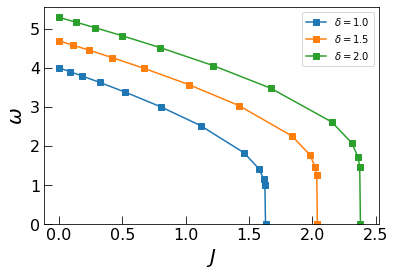

In [15]:
def get_ic(delta,f):
    y0 = (1-f) * yell(delta) + f * ysx_max(delta)
    return np.array([y0,0,0])
# Frequency at elliptic point
eigvals_ell = lambda d: np.linalg.eigvals(Njac_cons(yell(d),0,0,d)[:2,:2])
omega_J0 = lambda d: np.imag(eigvals_ell(d))[0]

fvals = np.concatenate((np.linspace(.3,0.8,5),1-np.logspace(-3.5,-1,5)))
N = len(fvals)

for delta in [1,1.5,2]:
    Jsx = sx_upper_action(delta) + sx_lower_action(delta)
    omega,J = np.zeros((2,N))
    for i,f in enumerate(fvals):
        J[i],omega[i] = get_action_and_frequency(delta,get_ic(delta,f))
    
    Js = np.concatenate(([Jsx],J,[0]))
    omegas = np.concatenate(([0],omega,[omega_J0(delta)]))
    order = np.argsort(Js)
    plt.plot(
        Js[order],
        omegas[order],
        's-',label=r"$\delta={:.1f}$".format(delta)
    )
    
    plt.scatter(Jsx,0)
    
plt.xlabel("$J$",fontsize=20)
plt.ylabel("$\omega$",fontsize=20)
plt.tick_params(labelsize=16,direction='in',size=8)
plt.ylim(ymin=0)

plt.legend()

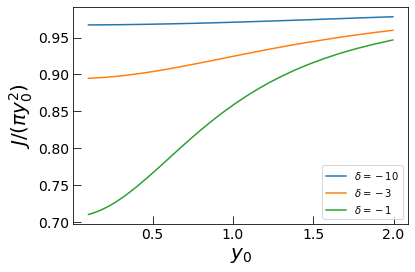

In [16]:
yvals = np.logspace(-1,0.3)
for delta in [-10,-3,-1]:
    data = np.zeros(yvals.shape)
    for i,y0 in enumerate(yvals):
        J,_=get_action_and_frequency(delta,np.array([y0,0,0]))
        data[i] = J / (np.pi * y0 * y0)
    plt.plot(yvals,data,label=r"$\delta={}$".format(delta))
plt.xlabel("$y_0$",fontsize=20)    
plt.ylabel("$J/(\pi y_0^2)$",fontsize=20)    
plt.legend()
plt.tick_params(direction='in',size=8,labelsize=14)

In [17]:
x,y,delta,tau = sympy.symbols("x,y,delta,tau")
dyvars=[y,x,delta]
flow = sympy.Matrix([ham.flow[0],ham.flow[1],1/tau])
jac = sympy.Matrix(3,3,lambda i,j: sympy.diff(flow[i],dyvars[j]))
Nflow = sympy.lambdify(dyvars + [tau],flow)
Njac = sympy.lambdify(dyvars + [tau],jac)
Nham=sympy.lambdify(dyvars,ham.H)
Hsxfn = lambda delta:  Nham(0,xunst(delta),delta)

In [18]:
def do_integration(pars):
    x0,y0,delta0,tau,tfin = pars
    fun = lambda t,y: Nflow(*y,tau).reshape(-1)
    Dfun  = lambda t,y: Njac(*y,tau)
    soln = solve_ivp(fun,(0,tfin),y0=[y0,x0,delta0],jac=Dfun,method="Radau")
    yfinal = soln.y[:,-1]
    return yfinal

In [19]:
def do_integration_dEbyEsx_vs_time(pars,**kwargs):
    x0,y0,delta0,tau,tfin = pars
    fun = lambda t,y: Nflow(*y,tau).reshape(-1)
    Dfun  = lambda t,y: Njac(*y,tau)
    soln = solve_ivp(fun,(0,tfin),y0=[y0,x0,delta0],jac=Dfun,method="Radau",**kwargs)
    t = soln.t
    y,x,delta = soln.y
    msk = delta > 1/3
    t,y,x,delta = [v[msk] for v in (t,y,x,delta)]
    Esx = Nham(0,xunst(delta),delta)
    E = Nham(y,x,delta)
    dEbyEsx = (E-Esx)/Esx
    return t,delta,dEbyEsx

In [20]:
def get_integration_results(pars):
    x0,y0,delta0,tau,tfin = pars
    fun = lambda t,y: Nflow(*y,tau).reshape(-1)
    Dfun  = lambda t,y: Njac(*y,tau)
    soln = solve_ivp(fun,(0,tfin),y0=[y0,x0,delta0],jac=Dfun,method="Radau",dense_output=True)
    return soln

In [21]:
def get_capture_probability_params(delta0,f0=0.5,Nsamples=200,tau=20,delta_padding = 1,t_padding = 0 ):
    # Get initial trajectory
    y0 = ysx_max(delta0) + f0 * (ysx_max(delta0)-yell(delta0))
    J,w,soln=get_action_and_frequency(delta0,[y0,0,0],solution=True)

    # Determine critical delta value
    # for separatrix encounter
    root = root_scalar(
        lambda d: 2*sx_upper_action(d)-J,
        bracket=[delta0,3*J],
        x0 = J       
    )
    delta_crit = root.root
    # Get a range of initial conditions along
    # original trajectory
    solnpts = soln.sol(np.linspace(0,2*np.pi/w, Nsamples))
    tfin = (delta_crit + delta_padding - delta0) * tau + t_padding
    pars = []
    for pt in solnpts.T:
        pars.append((pt[1],pt[0],delta0,tau,tfin)) 
    return delta_crit,pars

def get_capture_probability_result(delta0,f,Nsamples=200,tau=20,delta_padding = 1,t_padding = 0,pool=None):
    # Get initial trajectory
    delta_crit,pars = get_capture_probability_params(delta0,f,Nsamples,tau,delta_padding,t_padding)
    if pool:
        results = pool.map(do_integration,pars)
    else:
        results = list(map(do_integration,pars))
    results = np.array(results)
    
    
    hsx = Hsxfn(results[0,-1])
    
    dEbyEsx=np.array([(Nham(*y)-hsx)/hsx for y in np.array(results)])

    # Estimate capture probability as 
    # number captured divided by total number of simulations
    p_hat = np.sum(np.array(dEbyEsx)>0)/Nsamples

    # Poisson errorbar
    sigma = np.sqrt(p_hat*(1-p_hat)/Nsamples)

    return delta_crit,p_hat,sigma

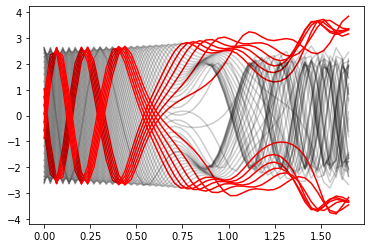

In [22]:
_,pars = get_capture_probability_params(1/3+0.1,5,Nsamples=50,tau=0.1,delta_padding=10)

for par in pars:
    sol=get_integration_results(par)
    T = np.linspace(sol.t[0],sol.t[-1])
    y,x,delta = sol.sol(T)
    Esx = Hsxfn(delta[-1])
    Efin = Nham(y[-1],x[-1],delta[-1])
    if Efin>Esx:
        plt.plot(T,y,'k',alpha=0.2)
    else:
        plt.plot(T,y,'r',alpha=1)

In [23]:
from rebound.interruptible_pool import InterruptiblePool
pool=InterruptiblePool()
all_results = []
for tau in np.logspace(-1,np.log10(3),4):
    results = [get_capture_probability_result(1/3+0.1,f,Nsamples=50,tau=tau,delta_padding=10,pool=pool) for f in np.linspace(0.1,5,10)]
    all_results.append(results)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


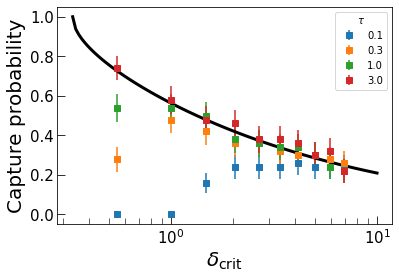

In [24]:
for tau,result in zip(np.logspace(-1,np.log10(3),4),all_results):
    plt.errorbar(*np.transpose(result),fmt='s',label="{:.1f}".format(tau))
plt.plot(np.logspace(np.log10(1/3),1,100),capture_prob_of_delta(np.logspace(np.log10(1/3),1,100)),lw=3,color='k')

plt.xlabel(r"$\delta_\mathrm{crit}$",fontsize=20)    
plt.ylabel(r"Capture probability",fontsize=20)
plt.tick_params(direction='in',labelsize=15,size=8)
plt.tick_params(direction='in',labelsize=15,size=6,which='minor')
plt.xscale('log')    
plt.legend(title=r"$\tau$")
